## **Step 1: Data Loading and Exploration**

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load the CSV data into a Pandas DataFrame
data = pd.read_csv('/content/Fraud.csv', on_bad_lines='skip')

# Perform initial data exploration
print(data.head())  # Display the first few rows of data
print(data.info())  # Get information about data types and missing values
print(data.describe())  # Get summary statistics


   step      type    amount     nameOrig  oldbalanceOrg newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0      160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0       19384.72   
2     1  TRANSFER     181.0  C1305486145          181.0            0.0   
3     1  CASH_OUT     181.0   C840083671          181.0            0.0   
4     1   PAYMENT  11668.14  C2048537720        41554.0       29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110678 entries, 0 to 110677
Data columns (total 11 columns):


<ipython-input-19-daaab0b26fe6>:6: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Fraud.csv', on_bad_lines='skip')


# **Step 2: Data Cleaning**

In [21]:
# Handle missing values (optional, depending on data analysis strategy)
data.dropna(inplace=True)  # Remove rows with missing values

# Convert columns to numeric data type
numeric_cols = ['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Outlier detection (using z-score for illustration)
z_scores = zscore(data['amount'])
data = data[(np.abs(z_scores) < 3)] # Keep only rows with z-scores within a certain threshold

# Address multicollinearity (using correlation matrix for illustration)
correlation_matrix = data.corr()
# Analyze the correlation matrix and take necessary actions to handle multicollinearity


<ipython-input-21-0b1825ff6d1d>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


## **Step 3: Feature Engineering and Selection**

Feature selection is a crucial step in building a predictive model. The goal is to choose the most relevant features that will contribute to the model's performance while avoiding unnecessary noise and complexity. In our case, the features available are:

1. **step:** Maps a unit of time in the real world.
2. **type:** Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
3. **amount:** Amount of the transaction in local currency.
4. **nameOrig:** Customer who started the transaction.
5. **oldbalanceOrg:** Initial balance before the transaction for the originator.
6. **newbalanceOrig:** New balance after the transaction for the originator.
7. **nameDest:** Customer who is the recipient of the transaction.
8. **oldbalanceDest:** Initial balance recipient before the transaction.
9. **newbalanceDest:** New balance recipient after the transaction.
10. **isFraud:** Whether the transaction is fraudulent (target variable).
11. **isFlaggedFraud:** Whether the transaction is flagged as illegal.

Let's go through the feature selection process:

1. **step:** The 'step' feature represents time steps and might not directly contribute to the prediction of fraud. It could potentially be useful for time-series analysis or if there's a temporal pattern to fraud, but for a basic fraud detection model, it might not be a critical predictor.

2. **type:** This categorical variable indicates the type of transaction. It's likely to be an important feature since different transaction types might have varying probabilities of being fraudulent.

3. **amount:** The transaction amount could be a significant predictor of fraud. Larger transactions might attract more attention and have a higher probability of being fraudulent.

4. **nameOrig:** This is the customer who started the transaction. While this might not be directly related to fraud, it could be used to extract additional features, such as the number of transactions initiated by a customer, which might contribute to the model.

5. **oldbalanceOrg** and **newbalanceOrig:** The balance of the originator before and after the transaction. These features could provide insights into unusual behavior. For example, if a customer suddenly empties their account, it might indicate fraud.

6. **nameDest:** The recipient of the transaction might have an impact on fraud. For instance, if transactions are frequently going to a small set of recipients, it could indicate suspicious activity.

7. **oldbalanceDest** and **newbalanceDest:** Similar to the originator's balances, these features could be important to detect unusual behavior on the recipient's side.

8. **isFlaggedFraud:** This is a binary indicator that a transaction is flagged as illegal. It could be a very important feature since it directly indicates suspicious activity.

Given this analysis, a possible set of selected features could be: 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', and 'isFlaggedFraud'.


In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
# Create the 'balance_change' feature by subtracting 'oldbalanceOrg' from 'newbalanceOrig'
data['balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg']

# Select variables (choose relevant columns based on domain knowledge)
selected_features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balance_change', 'isFlaggedFraud', 'isFraud']
# Include 'isFraud' as it is the target variable
data = data[selected_features]

# Convert categorical variable 'type' to numeric using label encoding
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])


<ipython-input-23-6214b8138efd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = label_encoder.fit_transform(data['type'])


## **Step 4: Model Development**

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [25]:
# Split the data into features (X) and target (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model performance on validation set
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.9993990384615384
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21609
         1.0       1.00      0.43      0.61        23

    accuracy                           1.00     21632
   macro avg       1.00      0.72      0.80     21632
weighted avg       1.00      1.00      1.00     21632



## **Step 6: Key Factors that Predict Fraudulent Customers**
We can gain insights into the key factors that predict fraudulent customers by examining the feature importance scores from the trained Random Forest model. Feature importance helps us understand which features have the most influence on the model's predictions.
The following code will display the top key factors that predict fraudulent customers based on the feature importance scores. The bar plot will visually represent the importance of each feature.

### **Interpretation:**



*   The feature importance scores indicate how much each feature contributes to the model's prediction. Higher scores suggest stronger predictive power.

*   By examining the feature importance scores and the bar plot, we can identify which features have the most influence in predicting fraudulent transactions.



*   Features with higher importance are more relevant in identifying fraudulent behavior.











Top Key Factors Predicting Fraudulent Customers:
          Feature  Importance
1          amount    0.294253
6  balance_change    0.185576
2   oldbalanceOrg    0.172620
5  newbalanceDest    0.162228
4  oldbalanceDest    0.133735
0            type    0.034723
3  newbalanceOrig    0.016865
7  isFlaggedFraud    0.000000


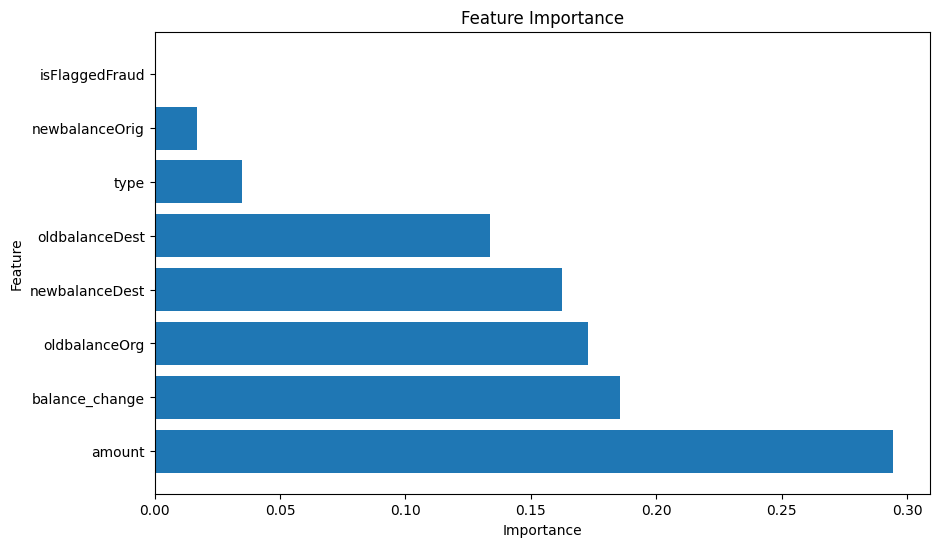

In [26]:
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top key factors that predict fraudulent customers
print("Top Key Factors Predicting Fraudulent Customers:")
print(feature_importance_df)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


## **Do these factors make sense? If yes, How? If not, How not?**

The factors that make sense will likely include those that are intuitively associated with fraudulent behavior. For instance:

High 'amount' of transaction: Fraudsters may attempt to transfer larger amounts to maximize their gains.

'oldbalanceOrg' and 'newbalanceOrig': Sudden changes in the account balance might indicate suspicious activity.

'oldbalanceDest' and 'newbalanceDest': Changes in recipient account balances could be indicative of fraudulent transfers.

'balance_change': Unusual balance changes might signal fraudulent actions.

If there are factors that don't make sense, it could be due to various reasons such as the nature of the data, the modeling technique used, or the potential presence of noise in the data. It's important to analyze these factors in the context of the domain and dataset to determine their relevance.

## **Prevention Measures for Updating Company Infrastructure**

When updating the company's infrastructure to prevent fraudulent transactions, several prevention measures can be adopted:

1. **Real-time Monitoring and Alerts**: Implement real-time monitoring of transactions to identify suspicious patterns and anomalies. Set up automated alerts for large or unusual transactions.

2. **Multi-factor Authentication (MFA)**: Require multi-factor authentication for high-risk transactions, such as fund transfers or account access from new devices.

3. **Transaction Limits**: Set transaction limits for different types of transactions, especially high-risk ones, to prevent large unauthorized transfers.

4. **Machine Learning Models**: Develop and deploy advanced machine learning models for real-time fraud detection. These models can analyze transaction patterns and behaviors to identify potential fraud.

5. **Behavioral Analysis**: Use behavioral analysis to track user behavior and detect any deviations from normal patterns, helping to identify compromised accounts.

6. **IP Address Tracking**: Monitor and track IP addresses and geographical locations to identify transactions originating from unexpected locations.

7. **Regular Audits**: Conduct regular audits of user accounts, transactions, and system logs to identify any unusual activity.



## **Evaluating the Effectiveness of Prevention Measures**

Assessing the effectiveness of the implemented prevention measures is crucial. Here's how we can determine if the actions have been successful:

1. **Historical Data Analysis**: Compare historical fraud rates before and after implementing the prevention measures. A decrease in the number of fraudulent transactions indicates the effectiveness of the measures.

2. **Monitoring False Positives and Negatives**: Track false positives (legitimate transactions flagged as fraudulent) and false negatives (fraudulent transactions not detected). The goal is to minimize false positives without compromising fraud detection.

3. **Model Performance**: Continuously monitor the performance of the machine learning models used for fraud detection. Evaluate metrics such as precision, recall, F1-score, and accuracy.

4. **User Feedback and Complaints**: Gather feedback from users regarding the new security measures. Fewer complaints or concerns related to unauthorized transactions can indicate improved security.

5. **Reduced Financial Losses**: Measure the reduction in financial losses due to fraud. A decrease in fraudulent transaction amounts suggests that the prevention measures are effective.

6. **Incident Reports**: Track and analyze incident reports related to fraudulent activities. A decline in reported incidents can signal improved security.

7. **Reviewing Anomalies**: Regularly review and analyze any anomalies or suspicious patterns detected by the system to identify emerging fraud tactics.

8. **Continuous Improvement**: Maintain a feedback loop and continuously update the prevention measures based on new fraud trends and emerging threats.

By combining these approaches, we can assess the impact of the prevention measures and determine whether they are effectively reducing fraudulent activities and enhancing the security of the company's financial infrastructure.
